In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs
from Bio.SeqUtils import GC
import matplotlib.pyplot as plt

Create a dictionary for accessing yeast genome data by chromosome.
Keys are chromosome numbers while values are file paths to the fasta file.

In [4]:
Spom_genome = {'chrI': 'D:\Winter 2021\BIMM 143\Schizosaccharomyces_pombe_chromosome_I.fa',
              'chrII': 'D:\Winter 2021\BIMM 143\Schizosaccharomyces_pombe_chromosome_II.fa',
              'chrIII': 'D:\Winter 2021\BIMM 143\Schizosaccharomyces_pombe_chromosome_III.fa'}

Open a text file containing the chromosomal positions of nucleosome centers in yeast.

In [5]:
data_spom = pd.read_fwf("D:\Winter 2021\BIMM 143\Spom_ncp.txt", widths = [6,11], names = ['chr', 'ncp'])
print(data.head(3))
print(data.tail(3))

    chr  ncp
0  chrI  506
1  chrI  645
2  chrI  836
          chr      ncp
75825  chrIII  2450667
75826  chrIII  2450999
75827  chrIII  2451616


Retrieving the nucleotide sequences flanking the nucleosome center position (the 'nucleosomecore') and writing them to an output file.
Here the flank width is 200 nucleotides.

Nucleosome center positions are screened and ones too close to the edge are dropped.

The chromosome sequences are opened one at a time as seq files to conserve memory.
Fission yeast has 3 pairs of chromosomes.

Intermediate data are printed out periodically to check for bugs and track code progress.

In [7]:
baselen = 200

for i in ['chrI','chrII','chrIII']:
    chrom = data_spom[data_spom['chr']==i].copy()
    print(chrom.head(1))
    print(chrom.tail(1))
    
    with open(Spom_genome[i]) as file:
        chrseq = SeqIO.read(file, "fasta")
        print(chrseq)
        
        chrom.drop(chrom[chrom['ncp']>(len(chrseq)-baselen)].index, inplace=True)
        chrom.drop(chrom[chrom['ncp']<baselen+1].index, inplace=True)
    
        chrom['nucleosomecore'] = chrom.apply(lambda row : chrseq.seq[row['ncp']-baselen-1:row['ncp']+baselen], axis = 1)
    
        print(chrom.head(1))
        print(chrom.tail(1))

       
    outfile = ''.join(["D:\Winter 2021\BIMM 143\Spom_nucleosomecore_", i, ".txt"])
    
    with open(outfile, "w") as file:
        chrom.to_csv(file, header=False, index=False)
        print('saved', i)

    chr  ncp
0  chrI  506
        chr      ncp
33830  chrI  5579015
ID: I
Name: I
Description: I Schizosaccharomyces_pombe
Number of features: 0
Seq('GATCACGTACATCACCTTGTAAGAATTTATCTGCAATAGTCCTTCGGTATTGTA...ATC', SingleLetterAlphabet())
    chr  ncp                                     nucleosomecore
0  chrI  506  (T, T, A, C, C, A, A, G, A, G, T, G, C, A, A, ...
        chr      ncp                                     nucleosomecore
33829  chrI  5578893  (G, C, T, C, A, A, C, A, A, T, T, T, G, C, A, ...
saved chrI
         chr  ncp
33831  chrII   63
         chr      ncp
61370  chrII  4539734
ID: II
Name: II
Description: II Schizosaccharomyces_pombe
Number of features: 0
Seq('GATCTCGCAACTCTTAATAAAGCTAATTCCTGCTAATTCGCTATACACTAAATC...TTT', SingleLetterAlphabet())
         chr  ncp                                     nucleosomecore
33832  chrII  224  (T, A, A, T, T, C, C, T, G, C, T, A, A, T, T, ...
         chr      ncp                                     nucleosomecore
61369  chrII  453

Nucleotide dimer occurrences are tallied in a 400x16 data frame; each column represents a type of dimer while each row represents a dinucleotide frame along the DNA sequence surrounding the nucleosome.

The dinucleotide frame is looped over the 401bp sequence for each nucleosomecore; this results in a total of 400 frames, and the dataframe row index indicates the position of the first nucleotide in the nucleosomecore.

This process is done by reading the 3 files created earlier in chunks.
Sequences are screened and the ones containing Ns or have lengths shorter than 401 nucleotides are dropped.
Each chunk produces a 400x16 'chunk dimer dataframe'; the 'chunk dimer dataframe's are summed together, cell to cell, to produce a 400x16 'toal dimer dataframe'.

Intermediate data are printed out periodically to check for bugs and track code progress.

In [8]:
rows_read = 0
total_dimer_df = pd.DataFrame(np.zeros([400,16]), columns=['TG', 'TT', 'AT', 'TA', 'AA', 'GG', 'AG', 'CT', 'CA', 'TC', 'CC', 'AC', 'GC', 'GA', 'GT', 'CG'])
print(total_dimer_df.head(2))
print(total_dimer_df.tail(2))

for i in ['chrI','chrII','chrIII']:
    print('opening', i)
    csvname = ''.join(["D:\Winter 2021\BIMM 143\Spom_nucleosomecore_", i, ".txt"])
    chunks = pd.read_csv(csvname, chunksize = 10000, index_col=None, names=['chr', 'ncp', 'nucleosomecore'])

    for chunk in chunks:
        
        rows_read += len(chunk.index)
        print('rows read:', str(rows_read))
    
        length_check = chunk[chunk['nucleosomecore'].apply(lambda x: len(x) != baselen*2+1)].index
        N_check = chunk[chunk['nucleosomecore'].apply(lambda x: 'N' in x)].index
        droplist = list(set(length_check) | set(N_check))
        chunk.drop(droplist, inplace=True)
        print('rows discarded:', str(len(droplist)))
        
        chunk_dimer_df = pd.DataFrame(columns=['TG', 'TT', 'AT', 'TA', 'AA', 'GG', 'AG', 'CT', 'CA', 'TC', 'CC', 'AC', 'GC', 'GA', 'GT', 'CG'])
        print('empty chunk dimer')
        print(chunk_dimer_df.head(2))
        print(chunk_dimer_df.tail(2))
        
        for i in range(baselen*2):
            site_dict = chunk['nucleosomecore'].apply(lambda x: str(x[i:i+2])).value_counts().to_dict()
            chunk_dimer_df = chunk_dimer_df.append(site_dict, ignore_index = True)
    
        chunk_dimer_df.fillna(0, inplace=True)
        print('filled chunk dimer')
        print(chunk_dimer_df.head(2))
        print(chunk_dimer_df.tail(2))
        
        total_dimer_df = total_dimer_df + chunk_dimer_df
        print('total dimer count')
        print(total_dimer_df.head(2))
        print(total_dimer_df.tail(2))

    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    CG  
0  0.0  
1  0.0  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      GT   CG  
398  0.0  0.0  
399  0.0  0.0  
opening chrI
rows read: 10000
rows discarded: 2
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  558  1184  873  769  1234  326  503  573  619  644  367  521  399  643   
1  606  1182 

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  551  1125  880  744  1176  327  546  525  624  660  359  503  394  680   
1  526  1202  869  821  1281  324  550  599  676  545  329  524  350  626   

    GT   CG  
0  564  342  
1  466  312  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  644  1226  919  808  1105  383  627  539  576  616  294  533  346  577   
399  647  1224  899  687  1158  376  521  553  571  639  340  488  395  649   

      GT   CG  
398  513  294  
399  528  325  
total dimer count
       TG      TT      AT      TA      AA      GG      AG      CT      CA  \
0  3019.0  6145.0  4867.0  3993.0  6505.0  1794.0  2910.0  2938.0  3305.0   
1  3090.0  6377.0  4843.0  4294.0  6715.0  1636.0  2982.0  3235.0  3712.0   

       TC      CC      AC      GC      GA      GT      CG  
0  3512.0  1950.0  2766.0  2220.0  3404.0  2849.0  1645.0  
1  3038.0  1935.0  2667.0  1961.0  3217.0  2554.0  

The total dimer count dataframe is saved as a textfile.

In [9]:
with open("D:\Winter 2021\BIMM 143\Spom_nucleosomecore_dimers.txt", "w") as file:
        total_dimer_df.to_csv(file)
        print('saved dimer dataframe')

saved dimer dataframe


Counting how many nucleosomecores have been analyzed by summing across each row in the total dimer dataframe.
The sum should be the same for all 400 rows.

In [11]:
dimer_df = pd.read_csv("D:\Winter 2021\BIMM 143\Spom_nucleosomecore_dimers.txt", index_col=0)
print(dimer_df.apply(lambda row: sum(row), axis=1).value_counts())

75814.0    400
dtype: int64


The total dimer dataframe is normalized by the number of nucleosomecores analyzed (=total dimer counts per site).

In [14]:
rows_scrnd = 75814
difreq_df = dimer_df.apply(lambda x: x/rows_scrnd)

Dimer frequency is plotted all in one graph and in 4 different subgroups for clarity.

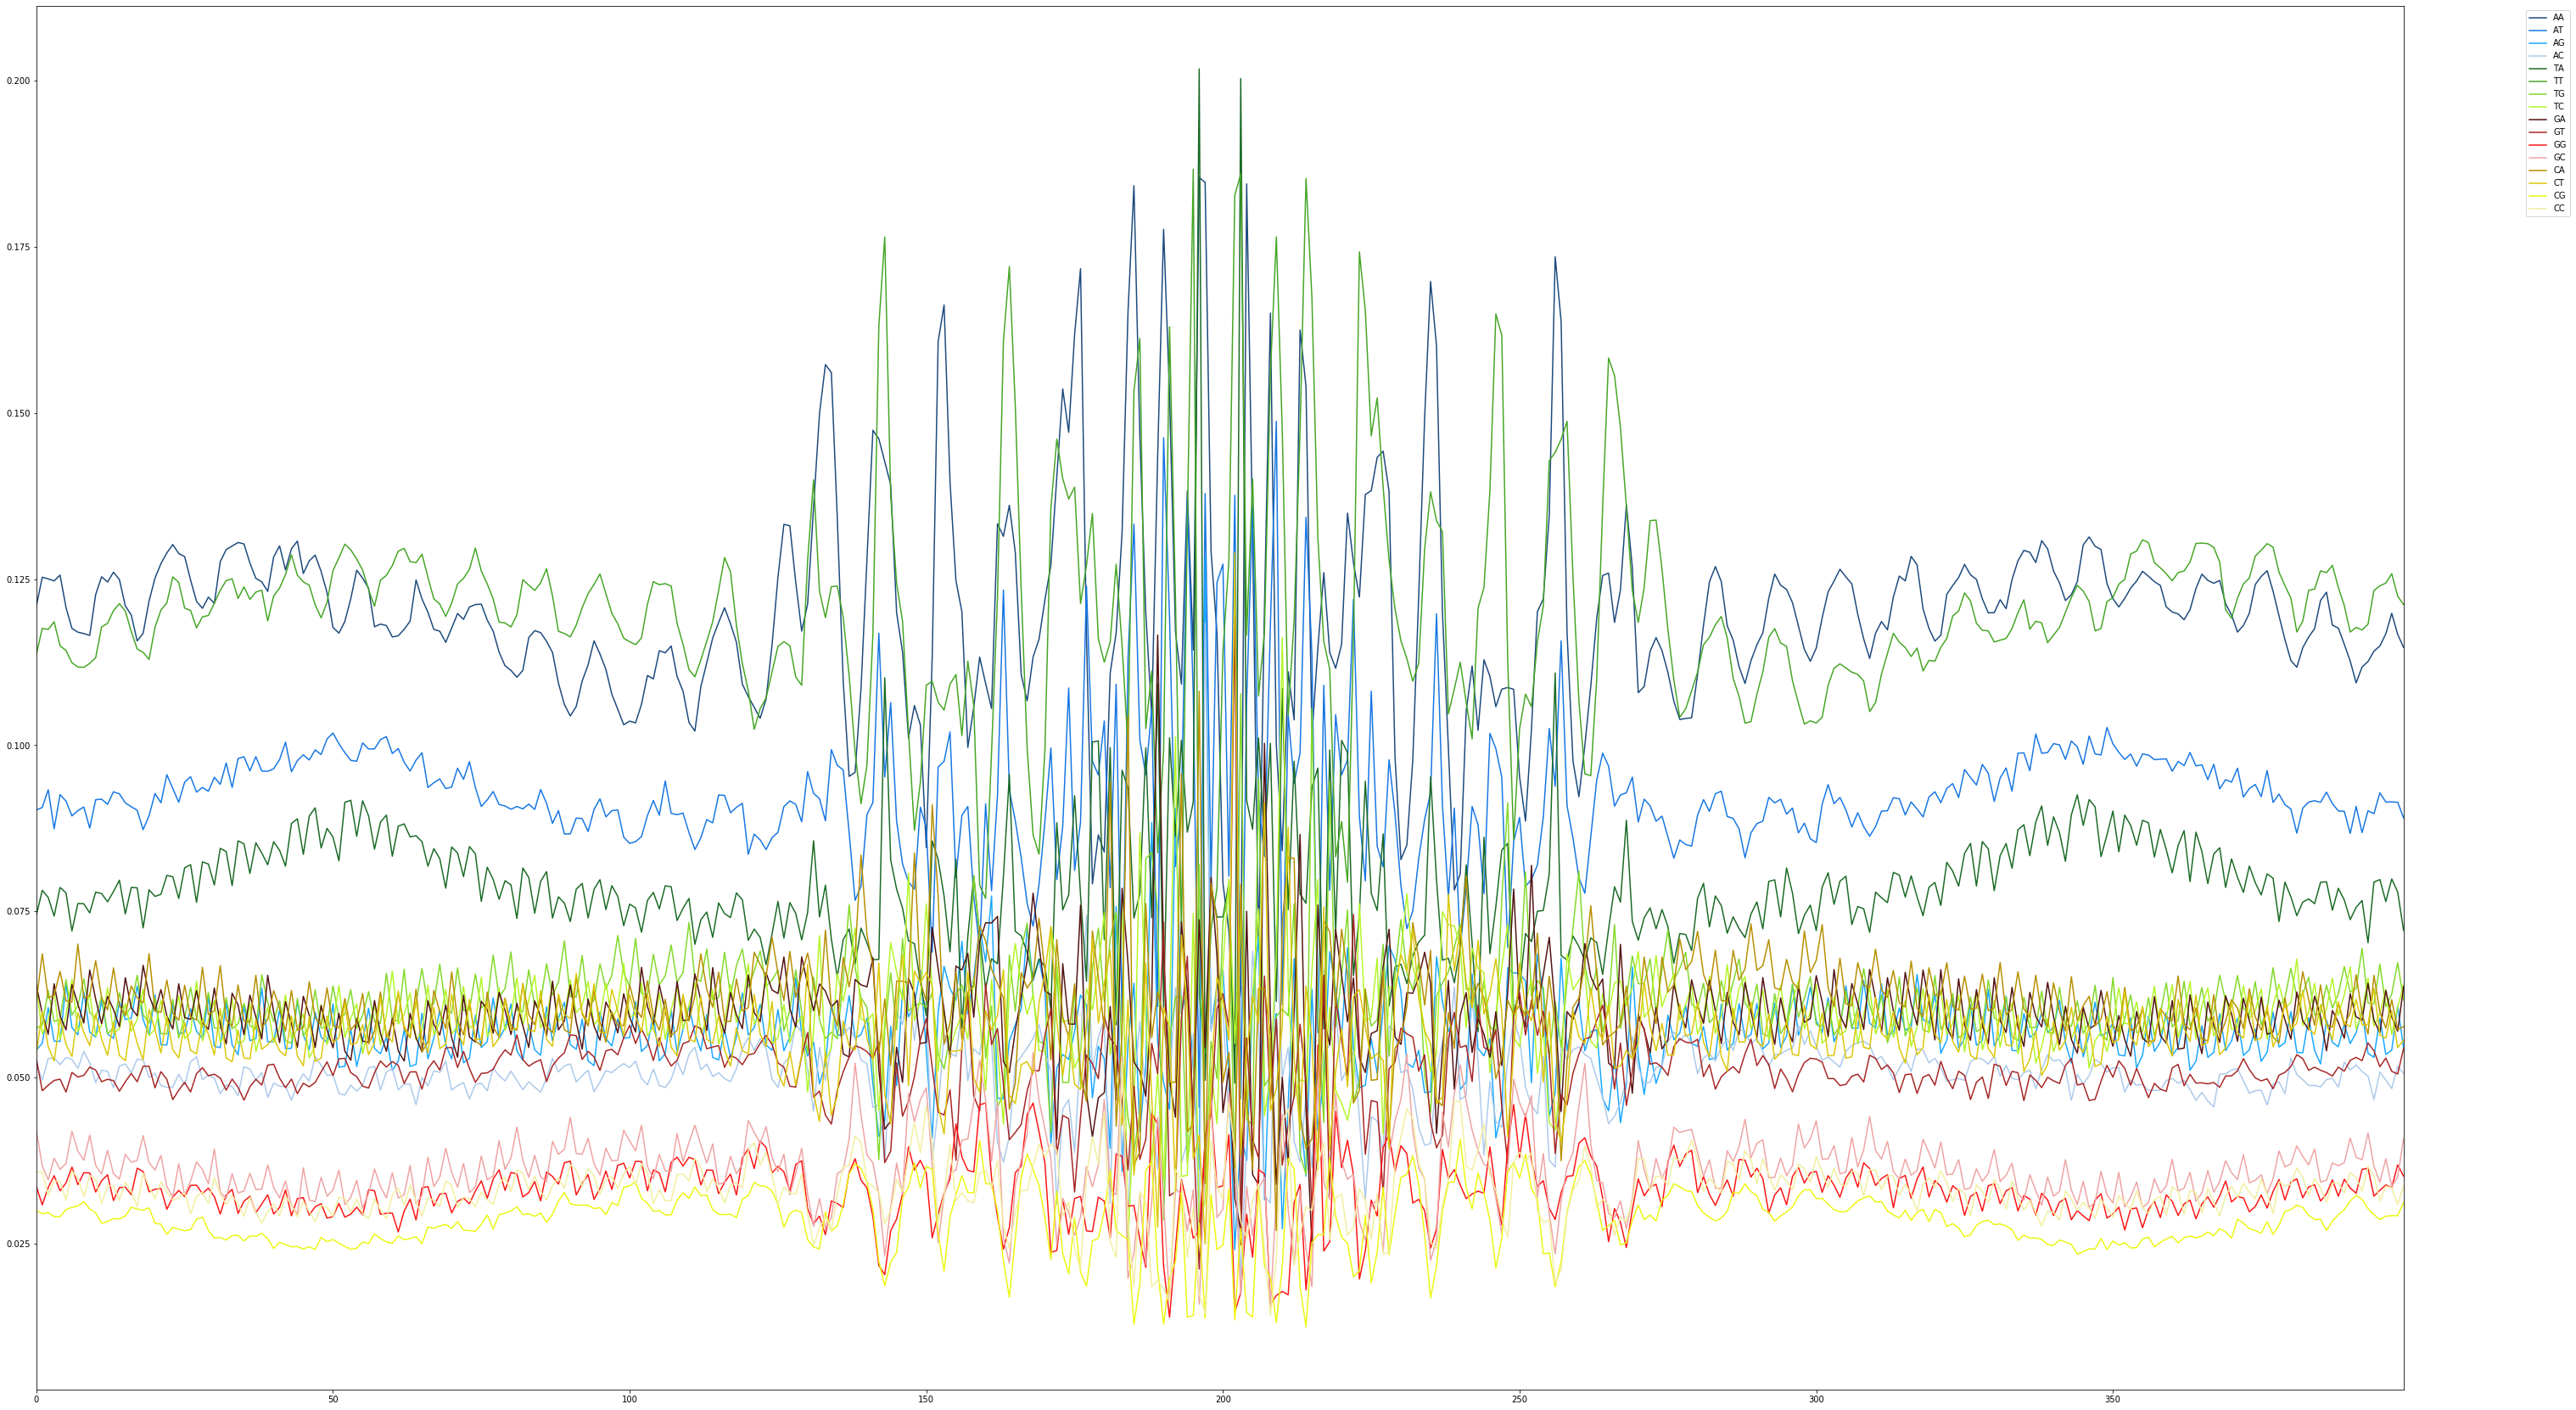

In [31]:
colors = ['#1C497C', '#1676E3', '#19A7FF', '#ACC9EB',
          '#1A6A25', '#45A625', '#82D92A', '#B4F627',
          '#531212', '#A62525', '#FF1414', '#EFA3A3',
          '#B78F00', '#DCC709', '#ECF711', '#F2EFA0']
difreq_df[['AA','AT','AG','AC','TA','TT','TG','TC','GA','GT','GG','GC','CA','CT','CG','CC']].plot(color = colors, figsize=(50,30))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

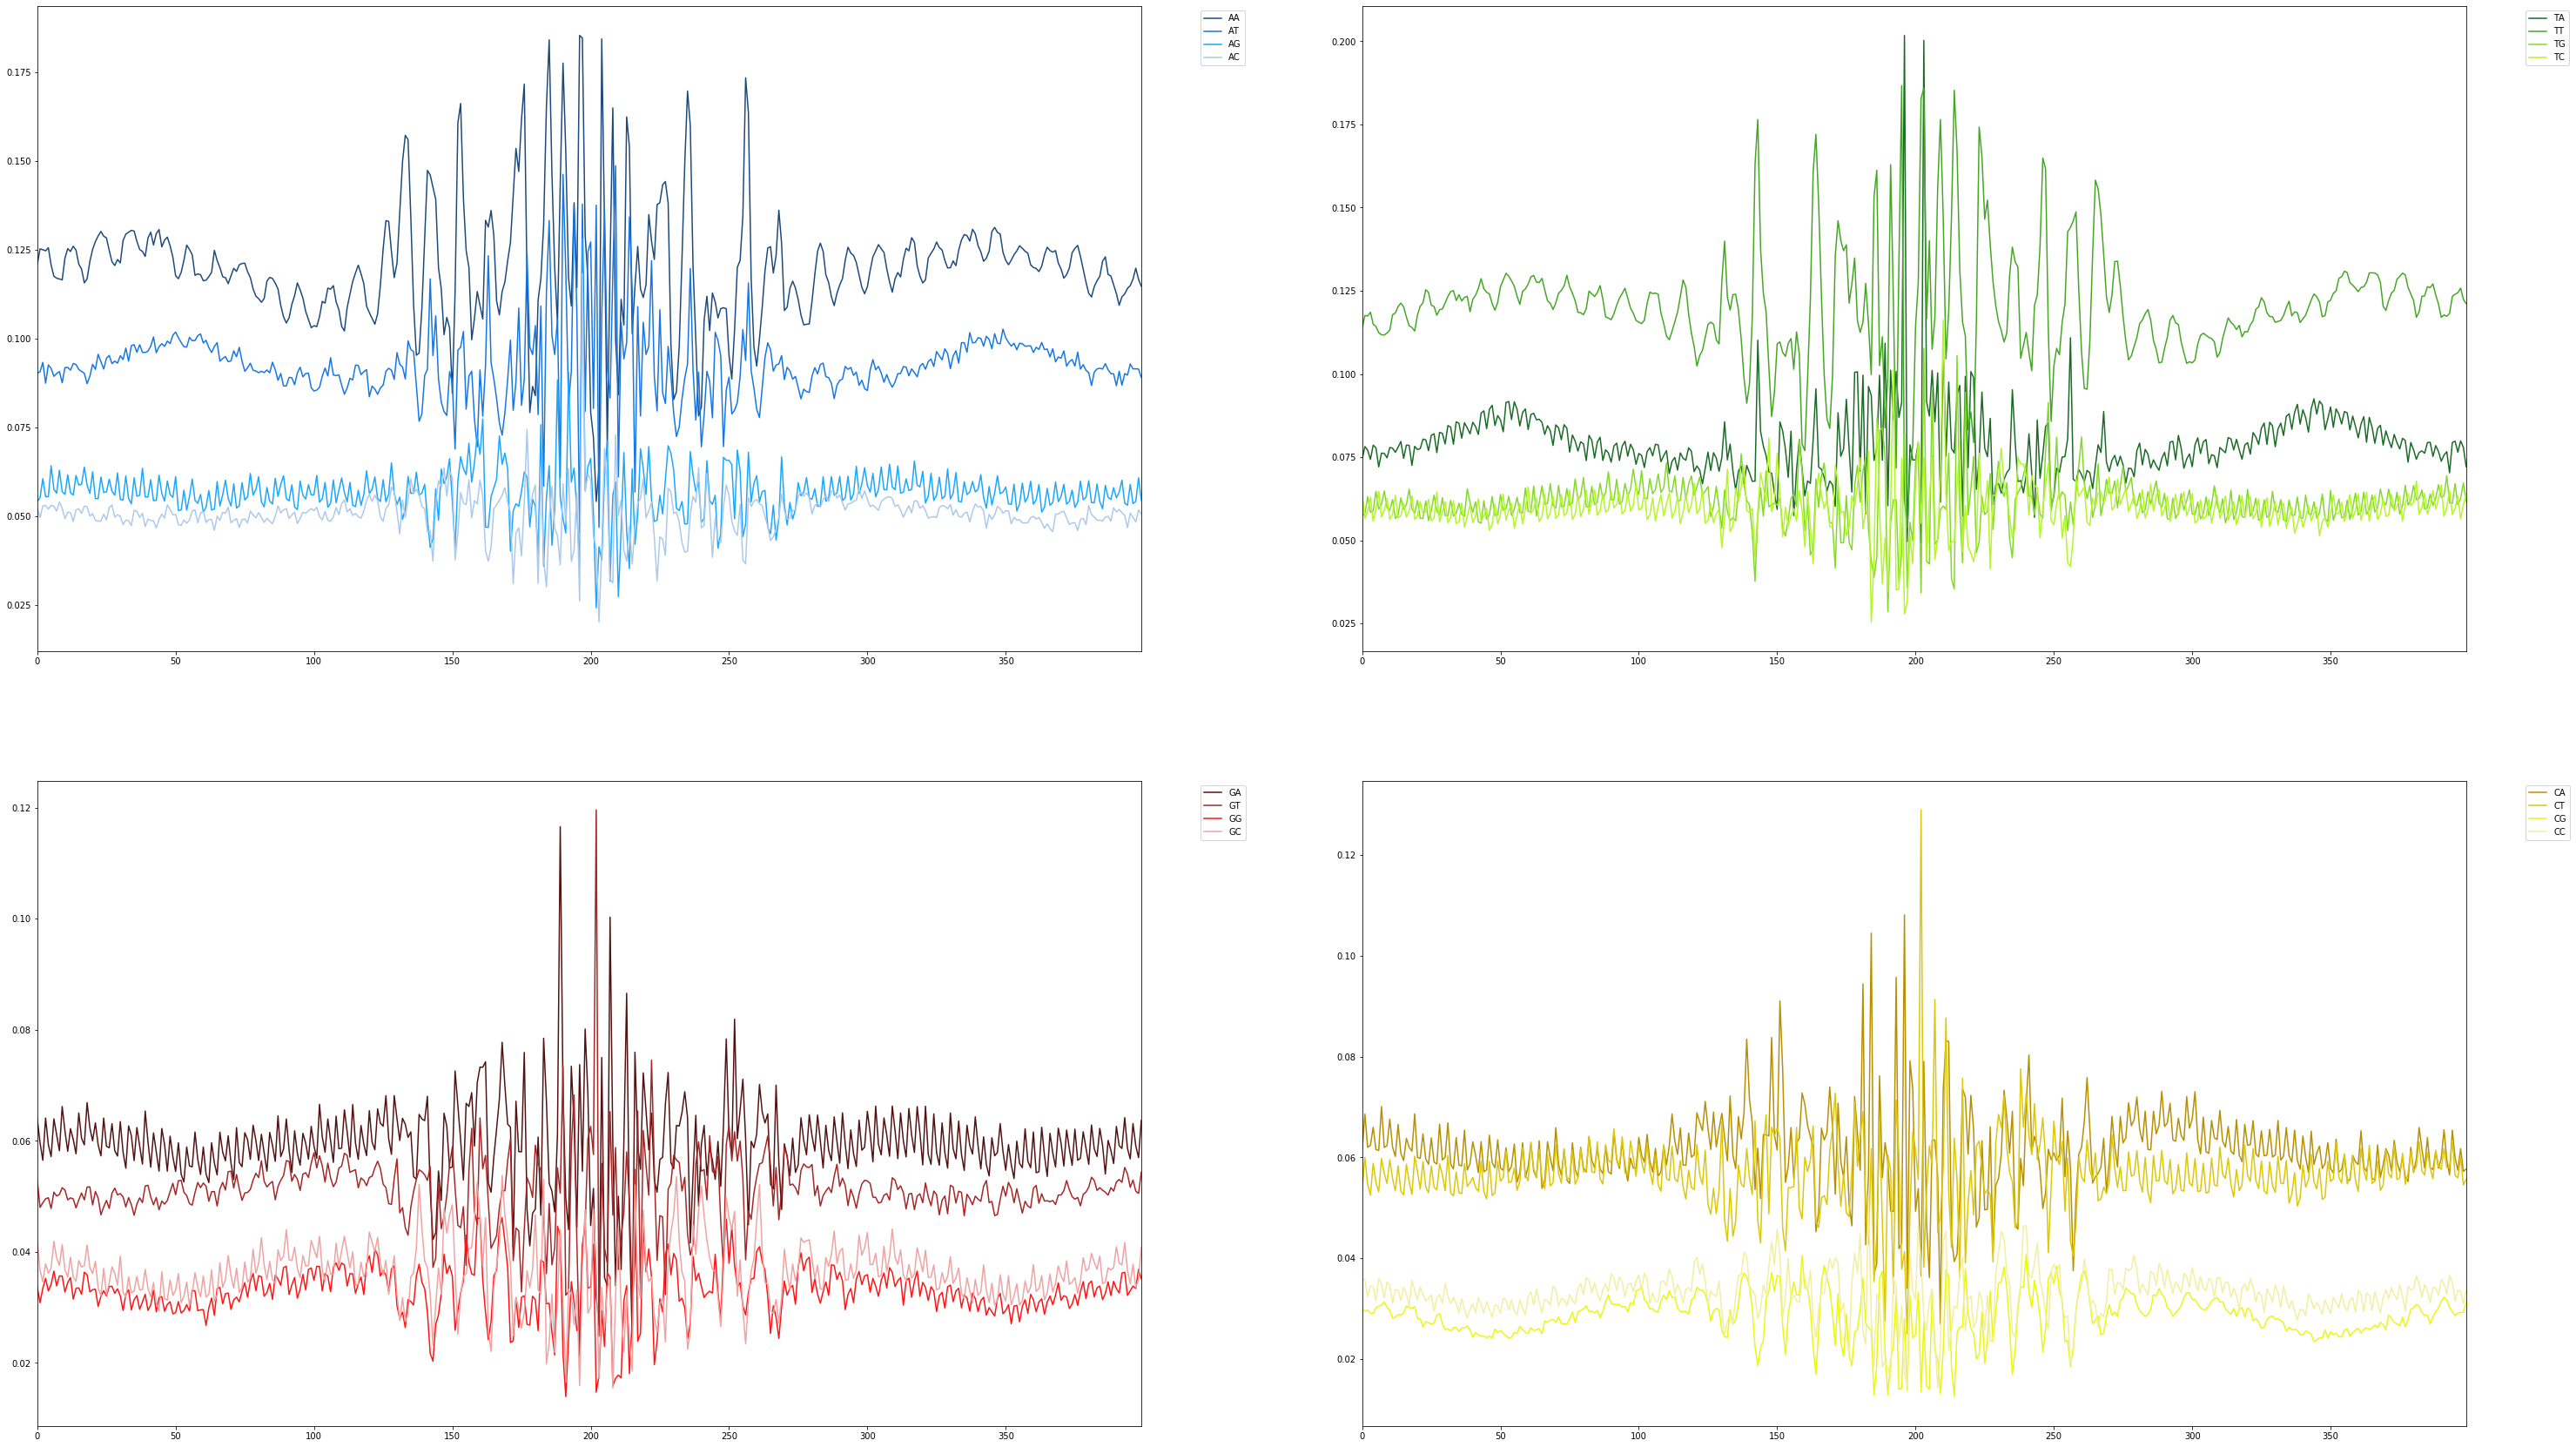

In [32]:
fig, axs = plt.subplots(2,2,figsize = (50, 30))

difreq_df[['AA','AT','AG','AC']].plot(ax=axs[0,0], color=['#1C497C', '#1676E3', '#19A7FF', '#ACC9EB'])
axs[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

difreq_df[['TA','TT','TG','TC']].plot(ax=axs[0,1], color=['#1A6A25', '#45A625', '#82D92A', '#B4F627'])
axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

difreq_df[['GA','GT','GG','GC']].plot(ax=axs[1,0], color=['#531212', '#A62525', '#FF1414', '#EFA3A3'])
axs[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

difreq_df[['CA','CT','CG','CC']].plot(ax=axs[1,1], color=['#B78F00', '#DCC709', '#ECF711', '#F2EFA0'])
axs[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

The GC content of the fission yeast genome is computed.

In [34]:
Spom_GC = GC(SeqIO.read(Spom_genome['chrI'], 'fasta').seq
            +SeqIO.read(Spom_genome['chrII'], 'fasta').seq
            +SeqIO.read(Spom_genome['chrIII'], 'fasta').seq)/100
Spom_pseudo = {"A":1-Spom_GC, "C": Spom_GC, "G": Spom_GC, "T": 1-Spom_GC}
print(Spom_pseudo)

{'A': 0.6394160909080785, 'C': 0.3605839090919215, 'G': 0.3605839090919215, 'T': 0.6394160909080785}


A list of nucleosomecore sequences is created to compute a position-weight-matrix for a 'nucleosomecore motif'.

In [65]:
instances =[]

for i in ['chrI','chrII','chrIII']:
    print('opening', i)
    csvname = ''.join(["D:\Winter 2021\BIMM 143\Spom_nucleosomecore_", i, ".txt"])
    chunks = pd.read_csv(csvname, chunksize = 10000, index_col=None, names=['chr', 'ncp', 'nucleosomecore'])

    for chunk in chunks:
        length_check = chunk[chunk['nucleosomecore'].apply(lambda x: len(x) != baselen*2+1)].index
        N_check = chunk[chunk['nucleosomecore'].apply(lambda x: 'N' in x)].index
        droplist = list(set(length_check) | set(N_check))
        chunk.drop(droplist, inplace=True)
        print('rows discarded:', str(len(droplist)))
        sequences = chunk['nucleosomecore'].apply(lambda x: Seq(x))
        instances = instances+(list(sequences))

opening chrI
rows discarded: 2
rows discarded: 0
rows discarded: 0
rows discarded: 0
opening chrII
rows discarded: 6
rows discarded: 0
rows discarded: 0
opening chrIII
rows discarded: 3
rows discarded: 0


The pseudocounts used by the biopython function is a dictionary of yeast genome GC content.

The postion-weight-matrix is plotted.

In [68]:
m = motifs.create(instances)
pwm = m.counts.normalize(pseudocounts=Spom_pseudo)
pwm_df = pd.DataFrame(pwm)

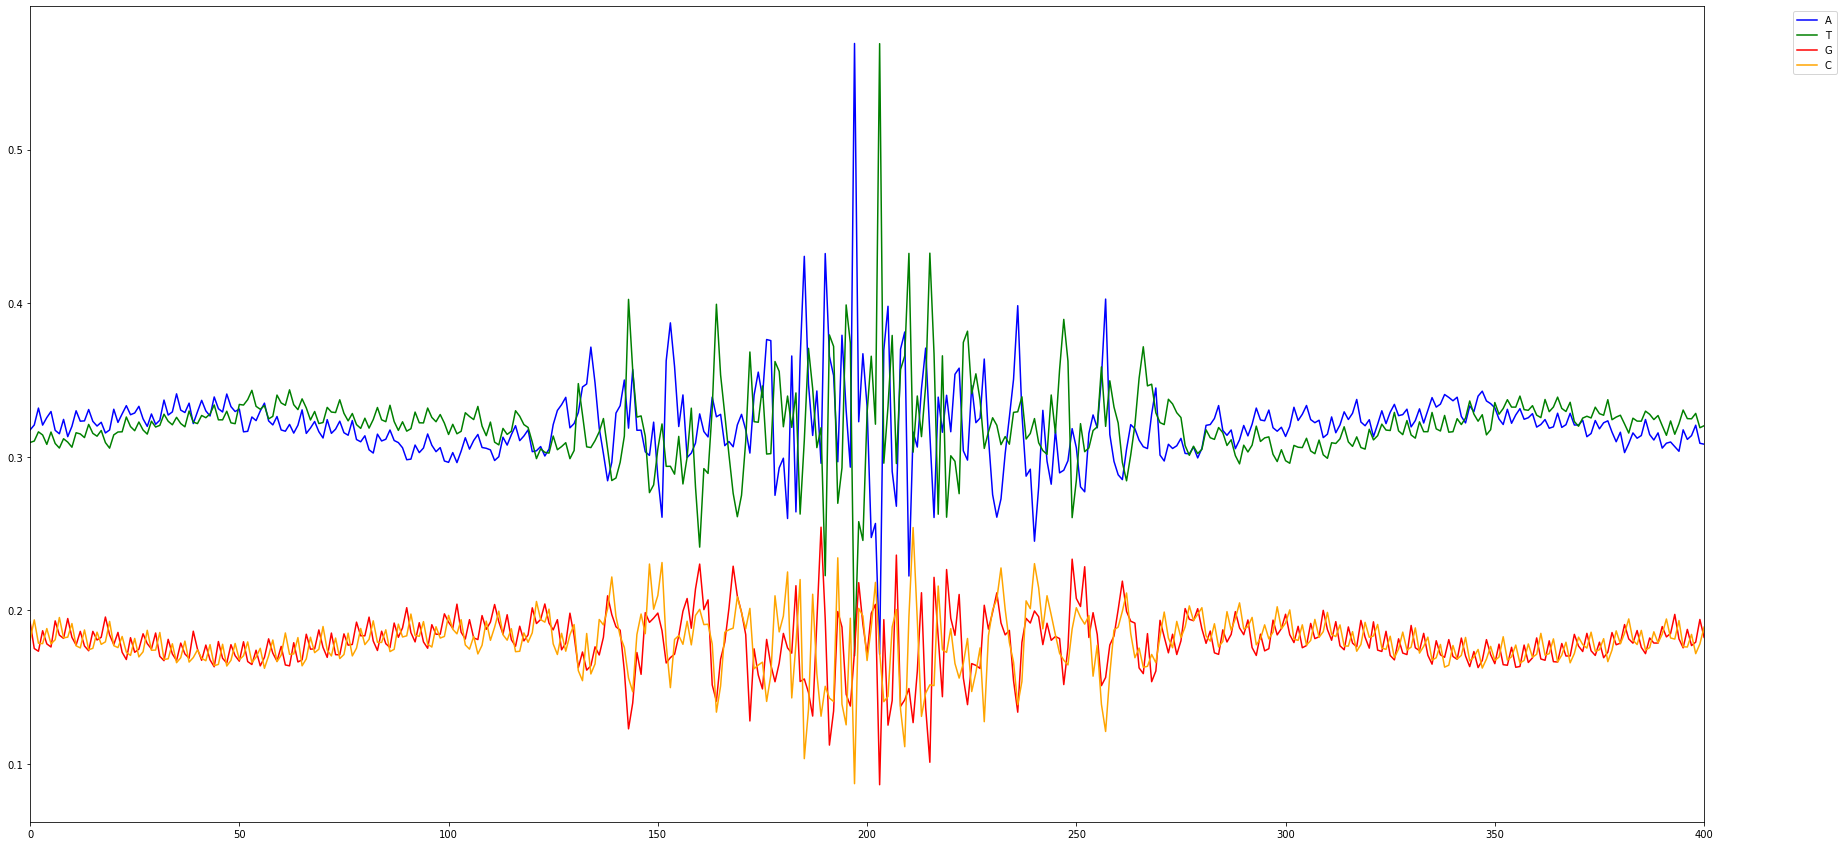

In [72]:
pwm_df[['A','T','G','C']].plot(figsize = (30, 15), color=['blue', 'green', 'red', 'orange'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The bases wrapped around the nucleosome show distinct frequency periodicity, especially for the ones right by the nucleosome center position. This indicates that nucleosomes in yeast are preferably situated at specific sequence profiles.